# Objective
To develop an intelligent system that can assess job candidates using both their resume text and structured profile data to predict whether they should be shortlisted for an interview.</br>
This project simulates a real-world application of deep learning in human resource analytics. It integrates natural language processing and tabular data modeling, encouraging students to apply multi-branch architectures, training strategies, and evaluation metrics used in modern AI systems.


# Data Preprocessing
We preprocess the `resume` dataset from kaggle by cleaning the dataset
* Removed URLs
* Removed Special Characters, non-printable emojis etc
* Extracted categorical and numerical features using `re` library

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [118]:
dataset = pd.read_csv("../dataset/UpdatedResumeDataSet.csv")
dataset

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


In [119]:
dataset["Category"].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [120]:
import re
import string
import unicodedata


# Function to clean text data
def clean_text(text):
    # Ensure string type
    text = str(text)

    # Normalize unicode to special chinese chars or whatever
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove unwanted symbols (non-printable, emojis, etc.), but KEEP digits and letters
    text = re.sub(r'[^a-zA-Z0-9\s:/\.\-]', ' ', text)  # keep things like "B.E.", "2015-2019", "C++", "Python-ML"

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

dataset["Resume"] = dataset["Resume"].apply(clean_text)

In [121]:
dataset

,Category,Resume
0,Data Science,skills programming languages: python pandas nu...
1,Data Science,education details may 2013 to may 2017 b.e uit...
2,Data Science,areas of interest deep learning control system...
3,Data Science,skills a r a python a sap hana a tableau a sap...
4,Data Science,education details mca ymcaust faridabad haryan...
...,...,...
957,Testing,computer skills: a proficient in ms office wor...
958,Testing,a willingness to accept the challenges. a posi...
959,Testing,personal skills a quick learner a eagerness to...
960,Testing,computer skills software knowledge ms-power po...


In [122]:

# Function to extract degree from cleaned text
def extract_degree(text):
    degrees = [
        'b\.tech', 'be', 'b\.e', 'mba', 'mca', 'bsc', 'msc', 'phd',
        'b\.com', 'm\.tech', 'b\.a', 'm\.a', 'bba', 'bca', 'm\.sc', 'm\.com'
    ]
    for deg in degrees:
        if re.search(deg, text, re.IGNORECASE):
            return re.sub(r'\\.', '', deg).upper()
    return 'UNKNOWN'

dataset['Degree'] = dataset['Resume'].apply(extract_degree)


<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:4: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_954/4175336605.py:4: SyntaxWarning: invalid escape sequence '\.'
  'b\.tech', 'be', 'b\.e', 'mba', 'mca', 'bsc', 'msc', 'phd',
/tmp/ipykernel_954/4175336605.py:4: SyntaxWarning: invalid

In [123]:
# Frequency of each degree
degree_counts = dataset['Degree'].value_counts()
print(degree_counts)

Degree
BE         717
UNKNOWN     90
MBA         74
MCA         29
BTECH       24
BA           8
MSC          8
BBA          4
BSC          4
BCOM         4
Name: count, dtype: int64


In [124]:
def extract_field(text):
    fields = ['computer science', 'mechanical', 'electrical', 'civil', 'electronics', 'finance', 'marketing', 'psychology', 'law', 'arts', 'business', 'data science']
    for field in fields:
        if re.search(field, text, re.IGNORECASE):
            return field.title()
    return 'Unknown'

dataset['Field'] = dataset['Resume'].apply(extract_field)

In [125]:
dataset['Field'].value_counts()
print(dataset['Field'].value_counts())

Field
Unknown             322
Business            132
Electronics         121
Computer Science    102
Electrical           58
Mechanical           52
Marketing            47
Arts                 44
Finance              32
Civil                26
Law                  14
Data Science          8
Psychology            4
Name: count, dtype: int64


### Feature Extraction
Extracting features such as
* Degree Field
* YOE
* Number of Previous Jobs
* Bool to check if applicant has github/linkedin/internship etc

In [126]:
import re
from datetime import datetime

def extract_yoe(text):
    # 1. Match formats like "3 years", "2.5 years", "5+ years"
    match = re.search(r'(\d+(\.\d+)?)\s*\+?\s*(years|yrs|year)', text, re.IGNORECASE)
    if match:
        return float(match.group(1))

    # 2. Match months and convert to years
    match = re.search(r'(\d+)\s*(months|month)', text, re.IGNORECASE)
    if match:
        return round(float(match.group(1)) / 12, 2)

    # 3. Match year ranges like "2018–2022", "from 2015 to 2020", etc.
    year_range = re.search(r'(?:(?:from)?\s*(\d{4}))\s*(?:-|\sto\s|–)\s*(\d{4})', text, re.IGNORECASE)
    if year_range:
        start_year = int(year_range.group(1))
        end_year = int(year_range.group(2))
        # Validate range
        if 1900 <= start_year <= end_year <= datetime.now().year:
            return float(end_year - start_year)

    return 0.0

dataset['YOE'] = dataset['Resume'].apply(extract_yoe)
print(dataset['YOE'].unique())



[2.000e+00 1.000e+00 5.000e-01 0.000e+00 6.000e+00 8.000e+00 8.000e+01
 3.000e+00 8.300e-01 1.000e+01 8.670e+00 3.300e-01 1.700e-01 9.000e+00
 5.000e+00 2.500e-01 1.420e+00 1.750e+00 1.250e+00 3.920e+00 1.920e+00
 1.300e+01 5.250e+00 1.500e+00 6.080e+00 2.250e+00 1.225e+01 1.500e+01
 2.080e+00 8.080e+00 3.580e+00 1.042e+01 2.500e+00 5.080e+00 1.100e+01
 4.000e+00 3.000e+02 4.080e+00 3.080e+00 3.250e+00 1.100e+00 2.830e+00
 1.330e+00]


In [127]:
def extract_num_jobs(text):
    # Count occurrences of "company -" or "employer -" or "worked at"
    return len(re.findall(r'(company\s*-|employer\s*-|worked at|at\s+[A-Z][a-z]+)', text, re.IGNORECASE))

dataset['NumJobs'] = dataset['Resume'].apply(extract_num_jobs)

# Frequency of number of jobs
num_jobs_counts = dataset['NumJobs'].value_counts()
print(num_jobs_counts)

NumJobs
2     218
1     177
3     140
4     115
5      62
7      52
9      40
6      31
10     24
8      23
11     20
12     12
27     10
32     10
13      8
14      7
22      6
26      6
37      1
Name: count, dtype: int64


In [128]:
import re

def extract_cgpa(text):
    text = text.lower()
    
    # Pattern 1: Number followed by /10 or /4, with optional labels like CGPA, GPA, etc.
    match = re.search(r'(cgpa|gpa|cg|cp)?\s*[:\-]?\s*(\d\.\d+|\d)\s*/\s*(10|4)', text)
    if match:
        return float(match.group(2)) / float(match.group(3))
    
    # Pattern 2: Label followed by value (e.g., CGPA: 8.5, GPA - 3.6, etc.)
    match = re.search(r'(cgpa|gpa|cg|cp)\s*[:\-]?\s*(\d\.\d+)', text)
    if match:
        return float(match.group(2)) / 10.0  # Assume out of 10 if not specified
    
    # Pattern 3: Just a value with /10 or /4 without any label
    match = re.search(r'(\d\.\d+|\d)\s*/\s*(10|4)', text)
    if match:
        return float(match.group(1)) / float(match.group(2))
    
    return 0.0

# Apply to your dataset
dataset["CGPA"] = dataset["Resume"].apply(extract_cgpa)

# Frequency of CGPA
cgpa_counts = dataset['CGPA'].value_counts()
print(cgpa_counts)

CGPA
0.00    922
0.81     22
0.50      8
1.00      4
0.75      4
0.70      2
Name: count, dtype: int64


In [129]:

def has_github(text):
    return int(bool(re.search(r'github\.com|gitlab\.com', text, re.IGNORECASE)))

def has_linkedin(text):
    return int(bool(re.search(r'linkedin\.com', text, re.IGNORECASE)))

def count_certifications(text):
    return len(re.findall(r'certificat(e|ion|ed)', text, re.IGNORECASE))

def has_internship(text):
    return int(bool(re.search(r'\bintern(ship)?\b', text, re.IGNORECASE)))

def count_projects(text):
    return len(re.findall(r'\bproject\b', text, re.IGNORECASE))

def has_management_exp(text):
    return int(bool(re.search(r'\b(manager|lead|supervisor|head)\b', text, re.IGNORECASE)))

def has_publications(text):
    return int(bool(re.search(r'\b(publication|paper|journal|conference)\b', text, re.IGNORECASE)))

def has_awards(text):
    return int(bool(re.search(r'\b(award|honor|achievement|scholarship)\b', text, re.IGNORECASE)))

def has_volunteer(text):
    return int(bool(re.search(r'\b(volunteer|ngo|social work)\b', text, re.IGNORECASE)))

def count_programming_languages(text):
    languages = ['python', 'java', 'c\+\+', 'c#', 'c ', 'javascript', 'sql', 'r ', 'matlab', 'php', 'ruby', 'go', 'swift', 'scala', 'perl']
    return sum(1 for lang in languages if re.search(r'\b' + lang + r'\b', text, re.IGNORECASE))

# Appyling the functions
dataset['HasGithub'] = dataset['Resume'].apply(has_github)
dataset['HasLinkedIn'] = dataset['Resume'].apply(has_linkedin)
dataset['Certifications'] = dataset['Resume'].apply(count_certifications)
dataset['HasInternship'] = dataset['Resume'].apply(has_internship)
dataset['NumProjects'] = dataset['Resume'].apply(count_projects)
dataset['HasManagementExp'] = dataset['Resume'].apply(has_management_exp)
dataset['HasPublications'] = dataset['Resume'].apply(has_publications)
dataset['HasAwards'] = dataset['Resume'].apply(has_awards)
dataset['HasVolunteer'] = dataset['Resume'].apply(has_volunteer)
dataset['NumProgLangs'] = dataset['Resume'].apply(count_programming_languages)

#

<>:29: SyntaxWarning: invalid escape sequence '\+'
<>:29: SyntaxWarning: invalid escape sequence '\+'
/tmp/ipykernel_954/3786021628.py:29: SyntaxWarning: invalid escape sequence '\+'
  languages = ['python', 'java', 'c\+\+', 'c#', 'c ', 'javascript', 'sql', 'r ', 'matlab', 'php', 'ruby', 'go', 'swift', 'scala', 'perl']


## Labelling the dataset
The fundamental problem of this dataset is that the data is unlabelled due to privacy concerns or due to the difficulty of manually labelling the resumes. To tackle this issue, we use a simple heuristic based approach to label the dataset.
NOTE: I am not using CGPA criterion since many of them have not provided their CGPAs

In [130]:
    # We now create a heuristic-based acceptance criteria based on the features extracted from resumes.
def heuristic_accept(row):
        score = 0
        if row['Degree'] != 'UNKNOWN': score += 1
        if row['YOE'] >= 2: score += 1
        if row['Certifications'] > 0: score += 1
        if row['NumProjects'] > 0: score += 1
        if row['HasGithub'] or row['HasLinkedIn']: score += 1
        if row['NumProgLangs'] > 1: score += 1
        if row['HasInternship']: score += 1
        if row['HasAwards'] or row['HasVolunteer']: score += 1
        # Accept if at least 4 out of 8 criteria are met
        return int(score >= 4)

dataset['Accepted'] = dataset.apply(heuristic_accept, axis=1)
print(dataset['Accepted'].value_counts())

Accepted
0    781
1    181
Name: count, dtype: int64




### Dataset Preparation

We perform the preprocessing needed to train a multimodal deep learning model using both tabular data and textual resumes.

#### Tabular Data
* Encodes categorical columns using **one-hot-encoding**
* Standardizes numerical columns to unit mean and variance

#### Textual Data
* Uses a pretrained `bert-base-uncased` tokenizer to convert texts in `dataset["Resume"]` to a vector of 128 dimensions(padding/truncation)

#### Dataset Class and DataLoaders
* The `ResumeBERTDataset` returns BERT tokens, tabular features and labels for class
* Pytorch Datasets are created with a batch_size of 16 to feed into the **Multimodal deep learning model**




In [131]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt

# --- Load and preprocess tabular data ---
categorical_cols = ['Degree', 'Field']
numerical_cols = [
    'CGPA', 'YOE', 'NumJobs', 'HasGithub', 'HasLinkedIn',
    'Certifications', 'HasInternship', 'NumProjects', 'HasManagementExp',
    'HasPublications', 'HasAwards', 'HasVolunteer', 'NumProgLangs'
]
target_col = 'Accepted'

# Encode tabular data
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(dataset[categorical_cols])

# Scale numerical features
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(dataset[numerical_cols])


# Stack encoded categorical and scaled numerical features   
X_tabular = np.hstack([X_cat_encoded, X_num_scaled]).astype(np.float32)
y = dataset[target_col].astype(np.float32).values.reshape(-1, 1)




In [132]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_bert(texts, max_len=128):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

from sklearn.model_selection import train_test_split

# Split indices
train_idx, val_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42)

# Then split everything using those indices
Xr_train = dataset["Resume"].iloc[train_idx].tolist()
Xr_val = dataset["Resume"].iloc[val_idx].tolist()

Xt_train = X_tabular[train_idx]
Xt_val = X_tabular[val_idx]

y_train = y[train_idx]
y_val = y[val_idx]



In [133]:
# --- Dataset Class ---
class ResumeBERTDataset(Dataset):
    def __init__(self, resumes, tabular, labels):
        self.encodings = tokenize_bert(resumes)
        self.tabular = torch.FloatTensor(tabular)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "tabular": self.tabular[idx],
            "label": self.labels[idx]
        }
    
train_ds = ResumeBERTDataset(Xr_train, Xt_train, y_train)
val_ds = ResumeBERTDataset(Xr_val, Xt_val, y_val)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)




### Model Definition & Training Loop

* **Model: `BERTTabularModel`**

  * Uses a pretrained BERT model (`bert-base-uncased`) to extract embeddings from resume text.
  * Tabular features are passed through a small MLP (`tabular_branch`).
  * The BERT and tabular outputs are concatenated and passed through a final classifier to predict acceptance probability.
  * BERT is frozen to reduce training time and overfitting.

* **Training Setup**

  * Binary Cross-Entropy Loss (`BCELoss`) is used.
  * Optimizer: Adam with a learning rate of 1e-3.
  * Epochs: 10 epochs

* **Training Loop**

  * Computes and stores loss and accuracy for each epoch on both train and validation sets.
  * Also calculates precision, recall, and F1-score during validation.



In [134]:
# --- Model ---
class BERTTabularModel(nn.Module):
    def __init__(self, tabular_dim):
        super().__init__()
        # Uses a pretrained BERT model to convert text to embeddings
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Freezing BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

        # Model to train on tabular data(numerical/categorical features)
        self.tabular_branch = nn.Sequential(
            # Layer 1
            nn.Linear(tabular_dim, 64),
            nn.ReLU(),

            # Layer 2
            nn.Linear(64, 64),
            nn.ReLU(),

            # Final Layer
            nn.Linear(64, 32),
            nn.ReLU()
        )

        # Combined final MLP classifier
        self.classifier = nn.Sequential(
            # Layer 1
            nn.Linear(768 + 32, 64),
            nn.ReLU(),

            # Dropout for regularization
            nn.Dropout(0.3),

            # Layer 2
            nn.Linear(64, 64),
            nn.ReLU(),

            # Final Layer
            nn.Linear(64, 1),

            # Final activation for binary classification
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, tabular):
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = bert_output.last_hidden_state[:, 0, :]  # [CLS] token

        tab_feat = self.tabular_branch(tabular)
        combined = torch.cat([cls_embedding, tab_feat], dim=1)
        return self.classifier(combined)

In [135]:
# Training setup
device = torch.device("cuda")
model = BERTTabularModel(tabular_dim=X_tabular.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 10

In [136]:
# --- Train Loop ---
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import os
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, epochs=n_epochs):
    # Redirect output to a log file
    os.makedirs("../models", exist_ok=True)
    log_file_path = "../models/training_logs.txt"
    log_file = open(log_file_path, "w")

    # Initialize lists to store losses and accuracies
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    all_preds, all_labels = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for batch in train_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'label' and k != 'tabular'}
            labels = batch["label"].to(device)
            tabular = batch["tabular"].to(device)

            preds = model(**inputs, tabular=tabular)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(labels)
            correct += ((preds > 0.5).float() == labels).sum().item()
            total += len(labels)

        train_losses.append(total_loss / total)
        train_accs.append(correct / total)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        all_preds_epoch, all_labels_epoch = [], []
        with torch.no_grad():
            for batch in val_loader:
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'label' and k != 'tabular'}
                labels = batch["label"].to(device)
                tabular = batch["tabular"].to(device)

                preds = model(**inputs, tabular=tabular)
                loss = criterion(preds, labels)

                val_loss += loss.item() * len(labels)
                val_correct += ((preds > 0.5).float() == labels).sum().item()
                val_total += len(labels)

                all_preds_epoch.extend(preds.cpu().numpy())
                all_labels_epoch.extend(labels.cpu().numpy())

        val_losses.append(val_loss / val_total)
        val_accs.append(val_correct / val_total)

        # Store predictions for final ROC curve
        all_preds.extend(all_preds_epoch)
        all_labels.extend(all_labels_epoch)

        # Compute metrics
        all_preds_np = np.array(all_preds_epoch)
        all_labels_np = np.array(all_labels_epoch)

        precision = precision_score(all_labels_np, all_preds_np > 0.5, zero_division=0)
        recall = recall_score(all_labels_np, all_preds_np > 0.5, zero_division=0)
        f1 = f1_score(all_labels_np, all_preds_np > 0.5, zero_division=0)
        auc_score = roc_auc_score(all_labels_np, all_preds_np)

        # Logging
        log_file.write(f"Epoch {epoch + 1}/{epochs}\n")
        log_file.write(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accs[-1]:.4f}\n")
        log_file.write(f"Val   Loss: {val_losses[-1]:.4f} | Val   Acc: {val_accs[-1]:.4f}\n")
        log_file.write(f"Val Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc_score:.4f}\n\n")

    log_file.close()

    # --- Plot ROC Curve ---
    fpr, tpr, _ = roc_curve(np.array(all_labels), np.array(all_preds))
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig("../plots/final_roc_curve.png")
    plt.close()

    return train_losses, val_losses, train_accs, val_accs

train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader)


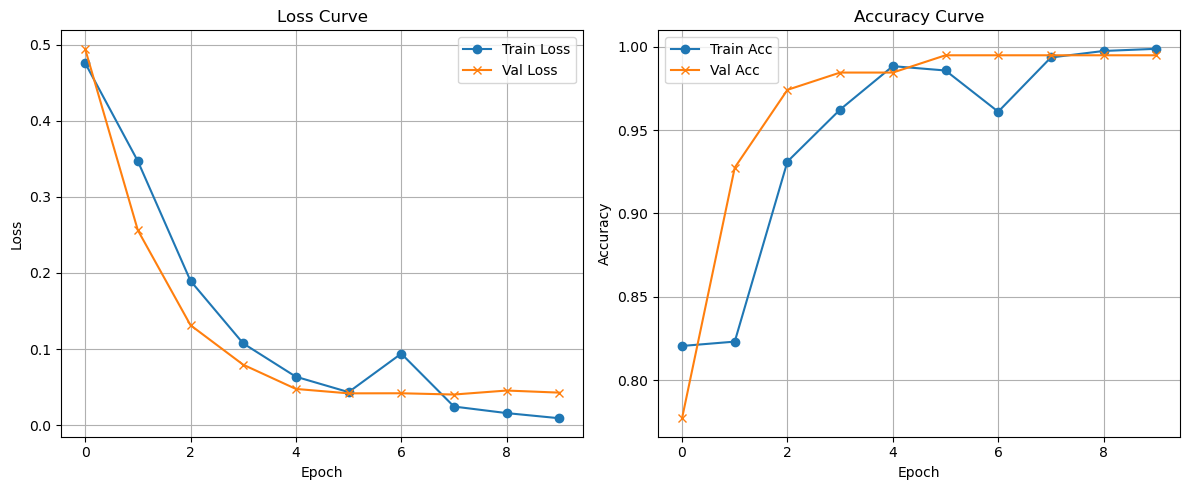

In [137]:
# --- Plot Training Loss and Accuracy ---
import matplotlib.pyplot as plt
import os

# Make sure output directory exists
os.makedirs("../models", exist_ok=True)

plt.figure(figsize=(12, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='x')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc", marker='o')
plt.plot(val_accs, label="Val Acc", marker='x')
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("../plots/training_curves.png")
plt.show()

# --- Save Model Weights ---
# torch.save(model.state_dict(), "../models/bert_tabular_model.pth")


## Final Evaluation on the Test Dataset

In [138]:
# --- Final Test Accuracy ---
model.eval()
test_correct, test_total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'label' and k != 'tabular'}
        labels = batch["label"].to(device)
        tabular = batch["tabular"].to(device)

        preds = model(**inputs, tabular=tabular)
        pred_labels = (preds > 0.5).float()

        test_correct += (pred_labels == labels).sum().item()
        test_total += len(labels)

        all_preds.extend(pred_labels.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_correct / test_total
print(f"\n Final Test Accuracy: {test_acc * 100:.2f}%")



 Final Test Accuracy: 99.48%


In [139]:
sample_resume = dataset["Resume"].iloc[7]
sample_tabular = X_tabular[7].reshape(1, -1)

# Tokenize the sample resume
sample_inputs = tokenize_bert([sample_resume])

# Remove token_type_ids if present
if 'token_type_ids' in sample_inputs:
    del sample_inputs['token_type_ids']



# Move BERT inputs to device
sample_inputs = {k: v.to(device) for k, v in sample_inputs.items()}

# Convert tabular input to tensor and move to device
sample_tabular_tensor = torch.tensor(sample_tabular, dtype=torch.float32).to(device)

# Predict
model.eval()
with torch.no_grad():
    output = model(**sample_inputs, tabular=sample_tabular_tensor)
    pred_label = (output > 0.5).float().item()

# Print result
print(f"Sample Resume Prediction: {'Accepted' if pred_label == 1.0 else 'Rejected'}")


Sample Resume Prediction: Accepted


In [140]:
for i in range(len(dataset)):

    if dataset['Accepted'].iloc[i] == 1:
        print(f"Resume {i} is Accepted")
        break

Resume 7 is Accepted
